<a href="https://colab.research.google.com/github/Sahanaka/Transfer-Learning/blob/main/Transfer_Learning_with_CifarDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **In this notebook we will use transfer learning to do predictions on the Cifar dataset**

**We will use the ResNet model on 10 classifications of the dataset**

## **Imports**

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


## **Parameters**

In [2]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # 10 classes

## **Visualization helpers**

In [3]:

#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## **Data Handling**
**This section handles loading and preprocessing of the data**.

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. We will load the dataset from Keras.

In [4]:
(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


### Visualize the dataset

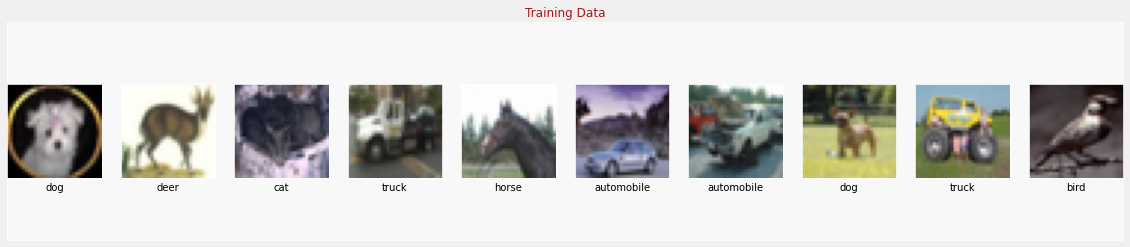

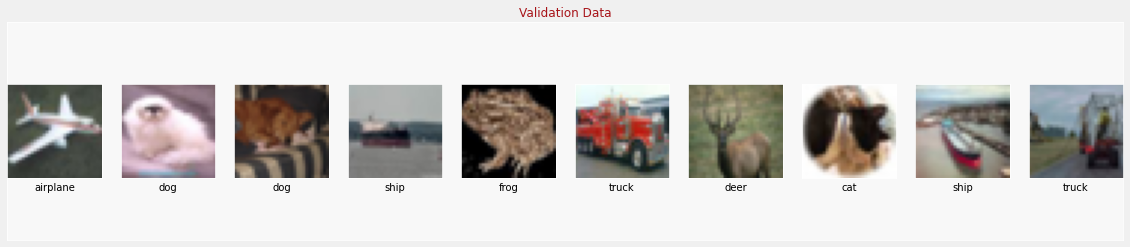

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data" )
display_images(validation_images, validation_labels, validation_labels, "Validation Data" )

In [6]:
print(len(training_images))
print(len(validation_images))

50000
10000


### Preprocess the dataset
We will normalize the dataset here. We can use the preprocess function of the ResNet model in keras

In [7]:
def preprocess_dataset(input_images):
  input_images = input_images.astype('float32')
  output_images = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_images

In [8]:
# Run on train, validation sets
train_X = preprocess_dataset(training_images)
val_X = preprocess_dataset(validation_images)

In [9]:
print(len(train_X))
print(len(val_X))

50000
10000


## **Model**

Transfer learning with the ResNet model. We will use the image net weights

**We will use the functional API to create the model. Feature extractor will be the ResNet model. And we will built a classifier for that features using the functional API**

In [10]:
# Feature extractor
# We shall pass include_top=False to avoid loading the builtin dense layers of the model. This allows us to add our own dense layers
# 224 x 224 x 3 is the input shape that ResNet was trained
def feature_extractor(inputs):
  feature_extractor = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                              weights='imagenet',
                                                              input_shape=(224, 224, 3))(inputs)
  return feature_extractor

In [11]:
# Classifier 
# Classifies the features extracted
# 10 class classification
def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(10, activation='softmax', name='Classifier')(x)
  return x

In [12]:
# Image resize
def resize_images(inputs):
  return tf.keras.layers.UpSampling2D(size=(7, 7))(inputs) # Images are 32 x 32, we need them to be 224, 224

In [13]:
def final_model(inputs):
  resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs) # Images are 32 x 32, we need them to be 224, 224

  resnet_feature_extractor = feature_extractor(resize)
  classification_output = classifier(resnet_feature_extractor)

  return classification_output

In [14]:
def define_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3)) # Input layer shape
  classification_output = final_model(inputs)
  return tf.keras.Model(inputs=inputs, outputs=classification_output)

In [15]:
model = define_model()

94781440/94765736 [==============================] - 1s 0us/step


In [19]:
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
 

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800

## **Training**

In [20]:
EPOCHS = 1 # Change later
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, validation_labels), batch_size=64)

782/782 [==============================] - 1066s 1s/step - loss: 0.3315 - accuracy: 0.8884 - val_loss: 0.3783 - val_accuracy: 0.8690


## **Evaluation**

In [22]:
loss, accuracy = model.evaluate(val_X, validation_labels, batch_size=64)

157/157 [==============================] - 63s 398ms/step - loss: 0.3783 - accuracy: 0.8690


### Results

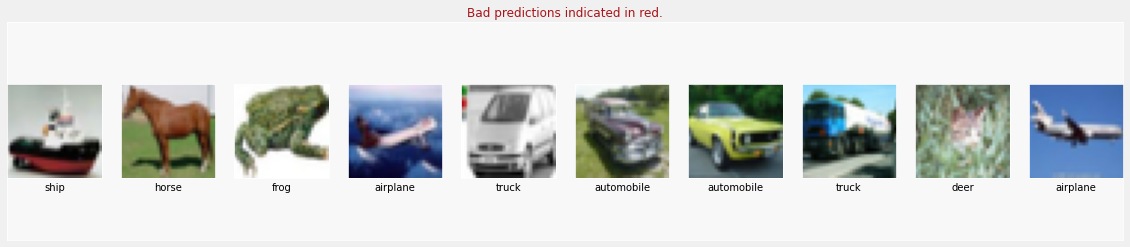

In [26]:
probabilities = model.predict(val_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")